<a href="https://colab.research.google.com/github/roydendsouza31/AI-Generated-Images-vs-Real-Images/blob/R2/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI Generated Images vs Real Images

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import cv2
import sklearn
import torch
from PIL import Image
from pathlib import Path
from fastai.vision.all import *
from fastai.callback import *
from fastai.metrics import error_rate
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.vision.all import get_image_files
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings ('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images

import zipfile

# Define the path to your zip file
file_path = '/content/ai-generated-images-vs-real-images.zip'  # Replace 'your_file.zip' with your file's name

!mkdir aigeneratedimagesvsrealimages

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/aigeneratedimagesvsrealimages')  # Replace 'destination_folder' with your desired folder

In [ ]:
path = Path('/content/aigeneratedimagesvsrealimages')
path.ls()
dls = ImageDataLoaders.from_folder(path, train='train', valid_pct=0.2,
                                          item_tfms=Resize(460),
                                          batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])

In [ ]:
len(dls.train_ds)

In [ ]:
len(dls.valid_ds)

In [ ]:
print(dls.vocab)

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

In [ ]:
learn.summary()

In [ ]:
learn.model_dir = "/kaggle/working/"

In [ ]:
suggest_funcs = (minimum, steep, valley, slide)

lrs = learn.lr_find(suggest_funcs=suggest_funcs)

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(lrs.valley, lrs.slide))
learn.recorder.plot_loss()

In [ ]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

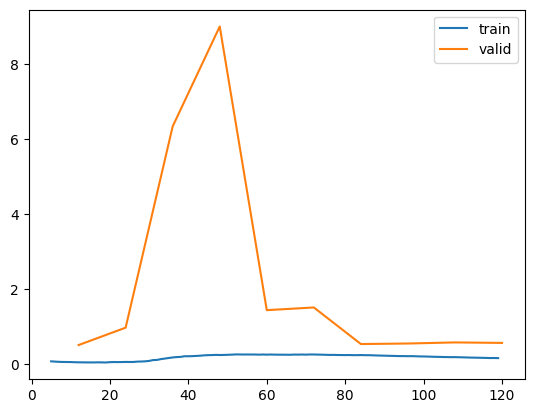

In [25]:
learn.fit_one_cycle(10, lr_max=slice(lrs.valley, lrs.slide))
learn.recorder.plot_loss()

In [20]:
# Save the trained model
learn.export('/content/drive/MyDrive/aigeneratedimagesvsrealimages.pkl')
# Load the saved model
#learn = load_learner('/content/drive/MyDrive/aigeneratedimagesvsrealimages.pkl')

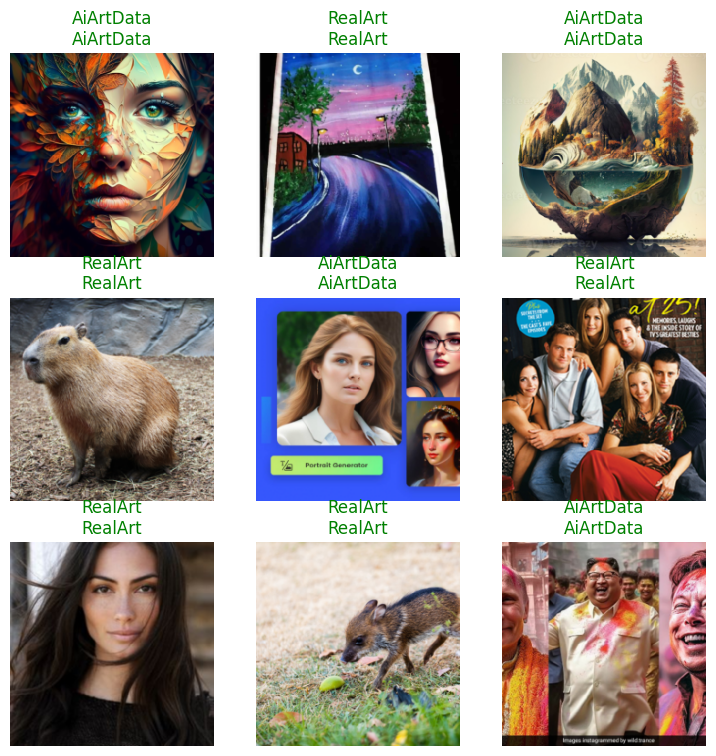

In [24]:
learn.show_results()

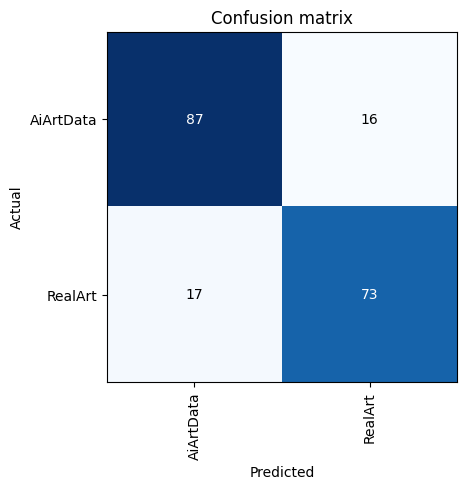

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

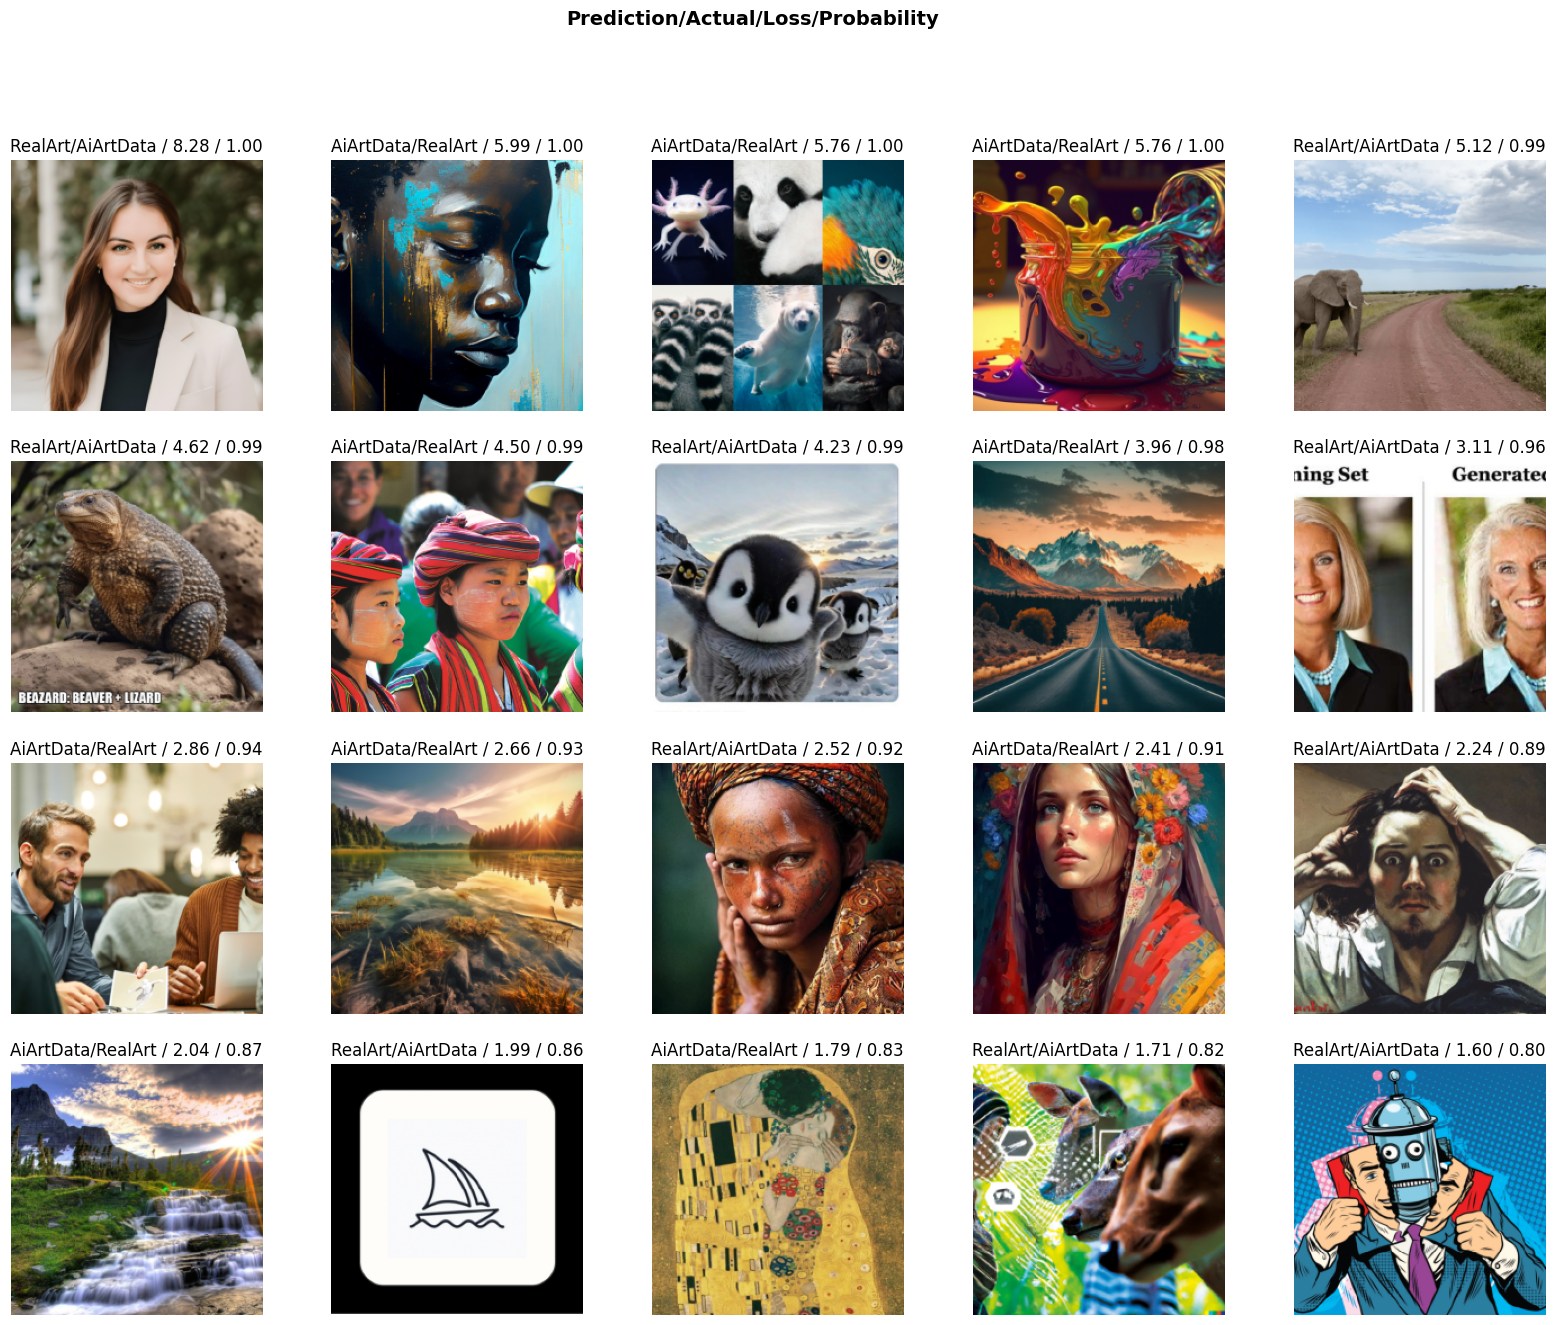

In [22]:
interp.plot_top_losses(20,figsize = (20,15))

In [21]:
preds, targets = learn.get_preds()

class_report = classification_report(targets, torch.argmax(preds, dim=1), target_names=dls.vocab)
print(class_report)

              precision    recall  f1-score   support

   AiArtData       0.84      0.84      0.84       103
     RealArt       0.82      0.81      0.82        90

    accuracy                           0.83       193
   macro avg       0.83      0.83      0.83       193
weighted avg       0.83      0.83      0.83       193

